<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex03/Marcus_Vinicius_Borela_de_Castro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Escreva aqui seu nome: Marcus Vinícius Borela de Castro

# PyTorch: Gradientes e Grafo Computacional

## Objetivos

Este notebook introduz 
- o conceito de autograd do PyTorch,
- uma interpretação numérica intuitiva do gradiente, e o
- grafo computacional, utilizado para o cálculo automático do gradiente de uma função.

Um dos principais fundamentos para que o PyTorch seja adequado para deep learning é a sua habilidade de
calcular o gradiente automaticamente a partir da expressões definidas. Essa facilidade é implementada
pelo tensor através do cálculo automático do gradiente pela construção dinâmica do grafo computacional.

# Configuração padrão 

In [51]:
import math

## Fixando a seed

In [1]:
import random
import torch
import numpy as np

In [2]:
def inicializa_seed():
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(123)
  np.random.seed(123)
  torch.manual_seed(123)
  #torch.cuda.manual_seed(123)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [3]:
inicializa_seed()

## Rastro (neptune.ai)

Gerado rastro da execução no Neptune (detalhes no artigo [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664))


### Importação de libraries para Rastro

In [4]:
pip install neptune-client

     |████████████████████████████████| 315 kB 5.9 MB/s 
     |████████████████████████████████| 829 kB 62.2 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 181 kB 56.4 MB/s 
     |████████████████████████████████| 132 kB 44.0 MB/s 
     |████████████████████████████████| 8.6 MB 41.5 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 138 kB 58.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 127 kB 51.7 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 130 kB 57.0 MB/s 
     |████████████████████████████████| 64 kB 1.8 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.15.2-py2.py3-none-any.whl size=565173 sha256=2e20f959f3e3776f214baee56149a3da2f94cd46bee0d63f798c867b176775ee
  Stored in directory: /root/.cache/pip/wheels/4f/ff/e6/2128c7fd2e85bd327f524d44b0792

In [5]:
pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=e98dc2d4c0b2e32385d7533c47ed3f68b73aaf43ae98f9467a10219a7f43a9d3
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [6]:
import getpass
import copy
from torchviz import make_dot
import neptune.new as neptune
import time
import re
import tempfile
import os

### Código Rastro

Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664), autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)



In [7]:
def converte_optimizer_state_dict(parm_optimizer)-> dict:
  # return str(hparam['optimizer'])
  return parm_optimizer.state_dict()['param_groups'][0]

In [8]:
class NeptuneRastroRun():
    se_geracao_rastro = True 
    neptune_project = ""
    tag_contexto_rastro = ""
    neptune_api_token = ""

    def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
      # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
      if self.__class__.se_geracao_rastro:      
        self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
        self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
        vparams = copy.deepcopy(parm_params)
        if "optimizer" in vparams:
          vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
        if 'criterion'  in vparams:
          vparams["criterion"] = str(vparams["criterion"])
        if 'device' in vparams:
          vparams['device'] = str(vparams["device"])
        self.device = vparams["device"]
        for tag in parm_lista_tag:
          self.run_neptune['sys/tags'].add(tag)
        self.run_neptune['parameters'] = vparams
        self.tmpDir = tempfile.mkdtemp()

    @property
    def run():
      return self.run_neptune

    @classmethod
    def ativa_geracao_rastro(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def def_contexto(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def desativa_geracao_rastro(cls):
     cls.se_geracao_rastro = False      

    @classmethod
    def retorna_status_geracao_rastro(cls):
     return cls.se_geracao_rastro      

    @classmethod
    def retorna_tag_contexto_rastro(cls):
     return cls.tag_contexto_rastro 

    @classmethod
    def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
      assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
      cls.neptune_api_token = neptune_api_token
      cls.tag_contexto_rastro = tag_contexto_rastro
      cls.neptune_project = neptune_project

    def salva_metrica(self, parm_metricas={}):
      #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
      if self.__class__.se_geracao_rastro:
        for metrica, valor in parm_metricas.items(): 
          self.run_neptune[metrica].log(valor)
 
    def gera_grafico_modelo(self, loader_train, model):
      if self.__class__.se_geracao_rastro: 
        # efetuar um forward 
        """
        se dataloader devolver x e y:
        x_, y_ = next(iter(loader_train))
        x_ = x_.to(device)
        outputs = model(x_)
        """
        # se dataloader devolver dict:
        dados_ = next(iter(loader_train))
        outputs = model(dados_['x'].to(self.device))
        #outputs = model(x_['input_ids'].to(self.device), x_['attention_mask'].to(self.device))

        nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
        make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
        self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
        self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      



    def stop(self):
      if self.__class__.se_geracao_rastro:         
        self.run_neptune.stop()


### Definindo parâmetros para o rastro



In [9]:
# NEPTUNE_API_TOKEN = getpass.getpass('Informe NEPTUNE_API_TOKEN')

In [10]:
NeptuneRastroRun.inicia_contexto('marcusborela/IA025', 'Aula 3 - construindo grafo computacional do Pytorch',   getpass.getpass('Informe NEPTUNE_API_TOKEN'))
#NeptuneRastroRun.desativa_geracao_rastro()

Informe NEPTUNE_API_TOKEN··········


# Grafo computacional

```
    y_pred = x * w
    e = y_pred - y
    e2 = e**2
    J = e2.sum()
```

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/GrafoComputacional.png" width="600pt"/>

Para conhecer com maior profundidade a diferenciação automática usando grafo computacional, veja esta nota de aula:
https://cs231n.github.io/optimization-2/

In [11]:
import torch

In [12]:
torch.__version__

'1.10.0+cu111'

## Se um tensor possui .requires_grad=True

In [13]:
y = 2 * torch.arange(0,4).float()
y

tensor([0., 2., 4., 6.])

In [14]:
x = torch.arange(0,4).float(); x

tensor([0., 1., 2., 3.])

In [15]:
w = torch.ones(1,requires_grad=True); w

tensor([1.], requires_grad=True)

## Cálculo automático do gradiente da função perda J

Seja a expressão: $$ J = \sum ((x  w) - y)^2 $$

Queremos calcular a derivada de $J$ em relação a $w$.

### Montagem do grafo computacional

In [16]:
# predict (forward)
y_pred = x * w

# cálculo da perda J: loss
e = y_pred - y
e2 = e.pow(2)
J = e2.sum()
J

tensor(14., grad_fn=<SumBackward0>)

## Auto grad - processa o grafo computacional backwards

O `backward()` varre o grafo computacional a partir da variável a ele associada e calcula o gradiente para todos os tensores que possuem o atributo `requires_grad` como verdadeiro.
O `backward()` destroi o grafo após sua execução. Isso é intrínsico ao PyTorch pelo fato dele ser uma rede dinâmica.

In [17]:
J.backward()
print(w.grad)

tensor([-28.])


In [18]:
w.grad.data.zero_();

## Interpretação do Gradiente

O gradiente de uma variável final (J) com respeito à outra variável de entrada (w) pode ser interpretado como o quanto a variável final J vai aumentar se houver um pequeno aumento na variável de entrada (w).
Por exemplo suponha que o gradiente seja 28. Isto significa se aumentarmos a variável w de 0.001, então J vai aumentar de 0.028.

In [19]:
eps = 0.001
y_pred = x * (w + eps)
J_new = (y_pred - y).pow(2).sum()
J_new

tensor(13.9720, grad_fn=<SumBackward0>)

In [20]:
print(J_new - J)

tensor(-0.0280, grad_fn=<SubBackward0>)


## Backpropagation

Uma forma equivalente explícita de calcular o gradiente é fazendo o processamento do backpropagation no grafo computacional, de forma explícita.
Apenas como ilustração.

In [21]:
import numpy as np

dJ = 1.
de2 = dJ * np.ones((4,))
de = de2 * 2 * e.data.numpy()
dy_pred = de
dw = (dy_pred * x.data.numpy()).sum()
print(dJ)
print(de2)
print(de)
print(dw)

1.0
[1. 1. 1. 1.]
[ 0. -2. -4. -6.]
-28.0


## Visualizando o grafo computacional

In [22]:
!pip install torchviz

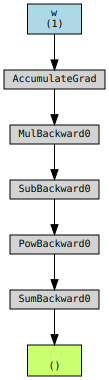

In [23]:
import torchviz
J = ((w * x) - y).pow(2).sum()
p = {'w':w} # dicionário de parâmetros
out = torchviz.make_dot(J,params=p)
out

Iremos agora visualizar a Resnet, que é uma rede neural bastante popular em visão computacional.

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

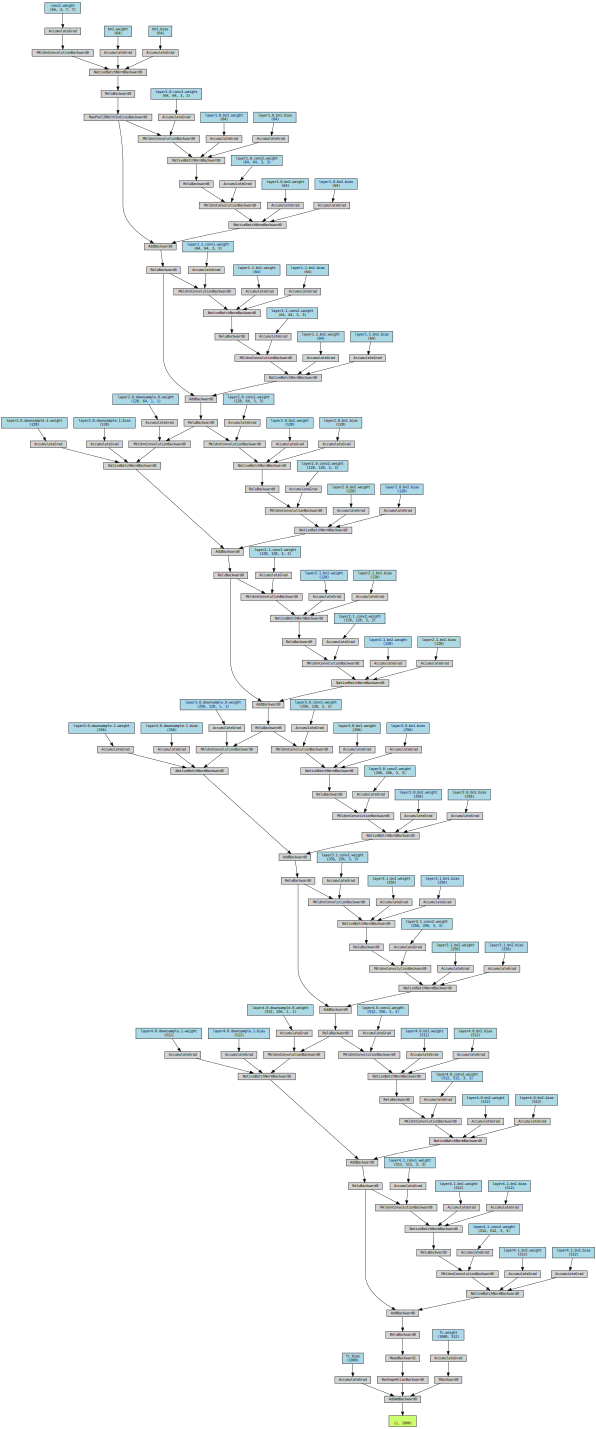

In [24]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
x_temp = torch.randn(1,3,224,224)  # First, create a random image.
y_temp = model(x_temp)  # We need one forward pass so the graph can be build.
out = torchviz.make_dot(y_temp, params=dict(model.named_parameters()))  # Create a figure from the computaional graph..
torchviz.dot.resize_graph(out, size_per_element=0.05)  # Resize to fit on the screen.
out

# Exercício 1

O que acontece com o grafo computacional após execução do `backward()`?

Resposta:

O backward pass se dá retrocedendo no grafo um estágio (nó) de cada vez, da direita para a esquerda, no cálculo das variáveis. Em cada nó, será calculado o gradiente local resultado da multiplicação dos valores das variáveis no forward pass pelo gradiente vindo das camadas posteriores (chain rule).

Ou seja, após a execução do backward, os parâmetros da rede terão seus gradientes calculados.

Caberáo ao comando optimizer.step() proceder à atualização dos pesos levando em conta os parâmetros do otimizador (learning rate, etc).

# Exercício 2

Execute um passo de atualização do valor de w, pelo 
gradiente descendente. Utilize um fator de aprendizado (*learning rate*) de 0.01 
para atualizar o `w`. Após, recalcule a função de perda:

    - w = w - lr * w.grad.data
    - Verifique o quanto que a perda J diminuiu

In [25]:
w, dw, w.grad.data

(tensor([1.], requires_grad=True), -28.0, tensor([0.]))

In [26]:
learning_rate = 0.01
w_novo = w - learning_rate * dw
w_novo

tensor([1.2800], grad_fn=<SubBackward0>)

In [27]:
eps = 0.001
y_pred = x * (w_novo + eps)
J_new = (y_pred - y).pow(2).sum()
J_new

tensor(7.2375, grad_fn=<SumBackward0>)

## Treinando uma rede no Pytorch

Para ajudar na entendimento dos exercícios abaixo, apresentamos o código em Pytorch para treinar uma rede de uma camada não-linear, com pesos `w` e `b`:
$y' = \sigma(wx + b)$

<img src="https://github.com/robertoalotufo/files/blob/master/figures/simple_graph.png?raw=true" width="600pt"/>

In [28]:
inicializa_seed()

In [29]:
from typing import List

In [30]:
class NonLinearPytorch(torch.nn.Module):
    def __init__(self):
        super(NonLinearPytorch, self).__init__()

        self.layer1 = torch.nn.Linear(1, 1)
        # Inicializa os pesos w e b em zero.
        self.layer1.load_state_dict(dict(weight=torch.zeros(1,1), bias=torch.zeros(1)))
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.layer1(x))
        return y_pred


In [31]:
learning_rate = 0.1
model = NonLinearPytorch()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [32]:
x = torch.tensor([-5], dtype=torch.float)
y_target = torch.tensor([0.76], dtype=torch.float)

In [33]:
num_iterations = 50
for i in range(num_iterations):
    # Zere os gradientes dos passo anterior.
    optimizer.zero_grad()
    # Rode a um passo forward do modelo.
    y_pred = model.forward(x)
    # Calcule a loss
    loss = loss_fn(y_pred, y_target)
    # Calcule os gradientes
    loss.backward()
    # Atualize os pesos
    optimizer.step()

    print(f'iter:{i}: y_prime: {y_pred} loss: {loss.item()} model.layer1.weight.data: {model.layer1.weight.data} model.layer1.bias.data {model.layer1.bias.data}')

iter:0: y_prime: tensor([0.5000], grad_fn=<SigmoidBackward0>) loss: 0.06759999692440033 model.layer1.weight.data: tensor([[-0.0650]]) model.layer1.bias.data tensor([0.0130])
iter:1: y_prime: tensor([0.5837], grad_fn=<SigmoidBackward0>) loss: 0.03108006715774536 model.layer1.weight.data: tensor([[-0.1078]]) model.layer1.bias.data tensor([0.0216])
iter:2: y_prime: tensor([0.6366], grad_fn=<SigmoidBackward0>) loss: 0.015220507979393005 model.layer1.weight.data: tensor([[-0.1364]]) model.layer1.bias.data tensor([0.0273])
iter:3: y_prime: tensor([0.6702], grad_fn=<SigmoidBackward0>) loss: 0.008060935884714127 model.layer1.weight.data: tensor([[-0.1562]]) model.layer1.bias.data tensor([0.0312])
iter:4: y_prime: tensor([0.6926], grad_fn=<SigmoidBackward0>) loss: 0.004541150294244289 model.layer1.weight.data: tensor([[-0.1706]]) model.layer1.bias.data tensor([0.0341])
iter:5: y_prime: tensor([0.7083], grad_fn=<SigmoidBackward0>) loss: 0.002676718169823289 model.layer1.weight.data: tensor([[-0.

# Exercício 3

Vamos agora escrever nosso próprio código para calcular os gradientes da rede apresentada acima.

Para tanto, temos que primeiro implementar a classe Tensor, que é parecida com a classe Tensor do pytorch. Quando instanciada, o objeto resultante armazena o valor do tensor e uma referencia para o nó do grafo computacional que gerou os valores do tensor, quando houver. Com isso podemos construir percorrer o grafo computacional no sentido reverso, realizando o passo `backward` do algoritmo de backpropagation.

Para simplificar a implementação, o gradiente também pode ser armazenado nesta variável. Com isso, podemos tratar os pesos da rede como Tensor's. Isso dispensa a necessidade de criarmos a classe Parameters, como é feito no pytorch.

In [47]:

class Tensor():
  def __init__(self, nome:str, data: float, previous_node=None, se_imp:bool=True, num_identacao:int=0):
    super().__init__()  
    self.nome = nome
    self.data = data
    self.previous_node = previous_node
    self.grad = 0
    self.se_imp = se_imp
    if self.se_imp:
      print("  "*num_identacao+f"Tensor().__init__ {self.descr} ")

  def backward(self, upstream_grad: float = None, num_identacao:int=0):
    if self.se_imp:
      print("  "*num_identacao+f"Tensor().backward (entrando) - self.nome: {self.nome}, self.previous_node: {self.previous_node} upstream_grad: {upstream_grad}")
    # Esta vai sr uma chamada recursiva cujo critéria de parada é quando previous_node==None.
    if upstream_grad is None:
      upstream_grad = 1
    if self.previous_node is None:
      self.grad += upstream_grad * self.data
    else:
      self.previous_node.backward(upstream_grad, num_identacao = num_identacao+1)
    if self.se_imp:
      print("  "*num_identacao+f"Tensor().backward (saindo) {self.nome}: grad= {self.grad}")

  @property
  def descr(self):
    return f"nome: {self.nome}; data: {self.data}; previous_node: {self.previous_node} grad: {self.grad}"


In [35]:
def print_tensor(x:'Tensor'):
  print(x.descr)

A seguir, implementaremos as funções `forward` e `backward` de cada um dos nós do grafo acima, além do nó de subtração, que é usado pela função de custo.
Vamos começar pelo nó da função sigmoid ($\sigma$), cuja derivada é:

$\frac{\delta\sigma}{\delta x} = \sigma(x)(1-\sigma(x))$

In [36]:
class SigmoidNode():
  def forward(self, x: Tensor, se_imp:bool=True, num_identacao:int=0)->float:
    # SigmoidNode: Cálculo da sigmoide 1/(1 + e^-x)
    self.x = x 
    exp = math.exp(x.data * -1)
    self.se_imp = se_imp
    val = 1/(1 + exp)
    self.saida = Tensor("o("+x.nome+")", val, self, se_imp=se_imp, num_identacao = num_identacao)    
    if self.se_imp:
      print("  "*num_identacao+f"SigmoidNode().forward: o({self.x.data}) resultado: {self.saida.descr}")
    return self.saida

  def backward(self, upstream_grad: float, num_identacao:int=0):
    # SigmoidNode().backward - cálculo do gradiente em relação a x: (1 – θ(x)) * θ(x)
    if self.se_imp:
      print("  "*num_identacao+f"SigmoidNode().backward (entrando) - upstream_grad: {upstream_grad} :: o({self.saida.nome}) ")
    if upstream_grad is None:
      upstream_grad = 1
    gradiente_local_x = (1 -  self.saida.data) * self.saida.data
    if self.se_imp:
      print("  "*num_identacao+f"SigmoidNode().backward  (saindo) - A seguir sobre parm.backward : {self.x.data} :: o({self.saida.nome}) ")
    self.x.backward(gradiente_local_x * upstream_grad, num_identacao = num_identacao+1)


Implementamos agora o `forward` e `backward` do nó da soma $z = x + y$, cujas derivadas parciais em relação a cada entrada $x$ e $y$ são:

$\frac{\delta z}{\delta x} = 1$

$\frac{\delta z}{\delta y} = 1$

In [37]:
class AddNode():
  def forward(self, x: Tensor, y: Tensor, se_imp:bool=True, num_identacao:int=0)->float:
    """
    AddNode: Cálculo da adição
    """
    self.x = x 
    self.y = y 
    self.se_imp = se_imp
    self.saida = Tensor("+("+self.x.nome +"," + self.y.nome+")", self.x.data + self.y.data, self, se_imp=se_imp, num_identacao = num_identacao)  
    if self.se_imp:
      print("  "*num_identacao+f"Saindo AddNode().forward: +({self.x.data},{self.y.data}) resultado: {self.saida.descr}")
    return self.saida     

  def backward(self, upstream_grad: float, num_identacao:int=0):
    """
    A operação de soma tem o objetivo de ser um "distribuidor", logo a derivada de z /derivada de x = 1 
      basta então, multiplicar 1 (gradiente local) pelo gradiente da frente.
    AddNode().backward - cálculo do gradiente em relação a x: (1 – θ(x)) * θ(x)
    """
    if self.se_imp:
      print("  "*num_identacao+f"AddNode().backward (entrando) {self.saida.nome} [+({self.x.data},{self.y.data})] - upstream_grad: {upstream_grad} :: {self.saida.nome}")
    if upstream_grad is None:
      upstream_grad = 1
    gradiente_local_x = 1
    gradiente_local_y = 1
    if self.se_imp:
      print("  "*num_identacao+f"AddNode().backward [+({self.x.data},{self.y.data})] - A seguir sobre parm1.backward: {self.x.data} :: {self.saida.nome}")
    self.x.backward(gradiente_local_x * upstream_grad, num_identacao = num_identacao+1)
    if self.se_imp:
      print("  "*num_identacao+f"AddNode().backward [+({self.x.data},{self.y.data})] - A seguir sobre parm2.backward: {self.y.data} :: {self.saida.nome}")
    self.y.backward(gradiente_local_y * upstream_grad, num_identacao = num_identacao+1)
  

Implementamos agora o `forward` e `backward` do nó da subtração $z = x - y$, cujas derivadas parciais em relação a cada entrada $x$ e $y$ são:

$\frac{\delta z}{\delta x} = 1$

$\frac{\delta z}{\delta y} = -1$

In [38]:
class SubNode():
  def forward(self, x: Tensor, y: Tensor, se_imp:bool=True, num_identacao:int=0)->float:
    # SubNode: Cálculo da adição
    self.x = x 
    self.y = y 
    self.se_imp = se_imp
    self.saida = Tensor("-("+self.x.nome+","+self.y.nome+")", self.x.data - self.y.data, self, se_imp=se_imp, num_identacao = num_identacao)    
    if self.se_imp:
      print("  "*num_identacao+f"Saindo SubNode().forward: -({self.x.data},{self.y.data}) resultado: {self.saida.descr}")
    return self.saida     
    
  def backward(self, upstream_grad: float, num_identacao:int=0):
    """
    A operação de soma tem o objetivo de ser um "distribuidor", logo a derivada de z /derivada de x = 1 
      basta então, multiplicar 1 (gradiente local) pelo gradiente da frente.
    SubNode().backward - cálculo do gradiente em relação a x: (1 – θ(x)) * θ(x)
    """
    if self.se_imp:
      print("  "*num_identacao+f"SubNode().backward (entrando) [-({self.x.data},{self.y.data})] - upstream_grad: {upstream_grad} :: {self.saida.nome}")
    if upstream_grad is None:
      upstream_grad = 1
    gradiente_local_x = 1
    gradiente_local_y = -1
    if self.se_imp:
      print("  "*num_identacao+f"SubNode().backward [-({self.x.data},{self.y.data})] - A seguir sobre parm1.backward: {self.x.data} :: {self.saida.nome}")
    self.x.backward(gradiente_local_x * upstream_grad, num_identacao = num_identacao+1)
    if self.se_imp:
      print("  "*num_identacao+f"SubNode().backward [-({self.x.data},{self.y.data})] - A seguir sobre parm2.backward: {self.y.data} :: {self.saida.nome}")
    self.y.backward(gradiente_local_y * upstream_grad, num_identacao = num_identacao+1)

Implementamos agora o `forward` e `backward` do nó da multiplicação $z = xy$, cujas derivadas parciais em relação a cada entrada $x$ e $y$ são:

$\frac{\delta z}{\delta x} = y$

$\frac{\delta z}{\delta y} = x$

In [39]:
class MulNode():
  def forward(self, x: Tensor, y: Tensor, se_imp:bool=True, num_identacao:int=0)->float:
    """
    MulNode: Cálculo da adição
    """
    self.x = x 
    self.y = y 
    self.se_imp = se_imp
    self.saida = Tensor("*("+self.x.nome +"," + self.y.nome+")", self.x.data * self.y.data, self, se_imp=se_imp, num_identacao = num_identacao)
    if self.se_imp:
      print("  "*num_identacao+f"Saindo MulNode().forward: *({self.x.data},{self.y.data}) resultado: {self.saida.descr}")
    return self.saida     
    
  def backward(self, upstream_grad: float, num_identacao:int=0):
    """
    A operação de soma tem o objetivo de ser um "distribuidor", logo a derivada de z /derivada de x = 1 
      basta então, multiplicar 1 (gradiente local) pelo gradiente da frente.
    MulNode().backward - cálculo do gradiente em relação a x: (1 – θ(x)) * θ(x)
    """
    if self.se_imp:
      print("  "*num_identacao+f"MulNode().backward (entrando) [*({self.x.data},{self.y.data})] - upstream_grad: {upstream_grad} :: {self.saida.nome}")
    if upstream_grad is None:
      upstream_grad = 1
    gradiente_local_x = self.y.data
    gradiente_local_y = self.x.data
    if self.se_imp:
      print("  "*num_identacao+f"MulNode().backward [*({self.x.data},{self.y.data})] - A seguir sobre parm1.backward: {self.x.data} :: {self.saida.nome}")
    self.x.backward(gradiente_local_x * upstream_grad, num_identacao = num_identacao+1)
    if self.se_imp:
      print("  "*num_identacao+f"MulNode().backward [*({self.x.data},{self.y.data})] - A seguir sobre parm2.backward: {self.y.data} :: {self.saida.nome}")
    self.y.backward(gradiente_local_y * upstream_grad, num_identacao = num_identacao+1) 

Agora que temos todos os nós implementados, podemos implementar as funções `forward` e `backward` de uma camada não-linear.

In [40]:
class NonLinear():
  def __init__(self, init_w:Tensor=Tensor('model.w', 1,se_imp=False, num_identacao = 1), init_b:Tensor=Tensor('model.b', 1,se_imp=False, num_identacao = 1), se_imp:bool=True):
    super().__init__()  
    self.se_imp = se_imp
    if self.se_imp:
      print(f"NonLinear().init")      
    # Inicializa os pesos w e b em zero.
    self._w = init_w
    self._b = init_b

  @property
  def parametros(self)->list:
    return [self._w, self._b]

  @property
  def w(self)->Tensor:
    return self._w

  @property
  def b(self)->Tensor:
    return self._b

  @property
  def parametros_valores(self)->str:
    return f"w: {self._w.data}, b: {self._b.data}"

  def forward(self, x: Tensor)->float:
    if self.se_imp:
      print(f"NonLinear().forward (entrando) {x.descr}")      
    result = SigmoidNode().forward(AddNode().forward(MulNode().forward(self._w, x, se_imp=self.se_imp, num_identacao = 3), self._b, se_imp=self.se_imp, num_identacao = 2), se_imp=self.se_imp, num_identacao = 1)
    if self.se_imp:
      print(f"NonLinear().forward: resultado: {result.descr}")
    return result

Para treinar esta rede, usaremos a função de custo Mean Squared Error (MSE):

$L = (y_\text{pred} - y_\text{target})^2$

Como por simplicidade optamos por não criar o nó de exponenciação, iremos substituir a operação de elevar ao quadrado pela multiplicacão das diferenças:
$L = (y_\text{pred} - y_\text{target}) * (y_\text{pred} - y_\text{target})$


In [41]:
def compute_loss(y_target: Tensor, y_pred: Tensor, se_imp:bool=True):
  if se_imp:
    print(f"\ncompute_loss (entrando): {y_target.descr} x {y_pred.descr}")
  result = MulNode().forward(SubNode().forward(y_target, y_pred, se_imp=se_imp, num_identacao = 2), SubNode().forward(y_target, y_pred, se_imp=se_imp, num_identacao = 2), se_imp=se_imp, num_identacao = 1)
  if se_imp:
    print(f"compute_loss saindo: resultado: {result.descr} \n")
  return result

Também precisamos criar a classe do optimizador SGD, para atualizar os pesos da rede.

In [42]:
class SGD():
  def __init__(self, parameters: List[Tensor], learning_rate: float, se_imp:bool=True):
    super().__init__()     
    self.se_imp = se_imp
    if self.se_imp:
      print(f"SGD().init parameters: {[parm.nome for parm in parameters]} learning_rate: {learning_rate}")      
    self.parameters = parameters
    self.learning_rate = learning_rate   

  def step(self):
    if self.se_imp:
      print(f"SGD().step ")      
    for parameter in self.parameters:
      parameter.data = parameter.data - learning_rate * parameter.grad

  def zero_grad(self):
    if self.se_imp:
      print(f"SGD().zero_grad ")      
    for parameter in self.parameters:
      parameter.grad = 0

Por fim, vamos aprender os pesos `w` e `b` para mapear um valor de entrada $x$ para um valor de saída $y_\text{target}$. Para isso, inicializamos o grafo da rede e rodamos o laço de optimização, que vai aplicar a descida do gradiente a cada iteração:

### Visualizando log do cálculo


In [44]:
se_imprime_calculo=True

In [52]:
model = NonLinear(se_imp=se_imprime_calculo)

NonLinear().init


In [53]:
# optimizer = SGD(parameters=[model.w, model.b], learning_rate=learning_rate)
learning_rate = 0.1
optimizer = SGD(parameters=model.parametros, learning_rate=learning_rate, se_imp=se_imprime_calculo)
x = Tensor('x', -5, se_imp=se_imprime_calculo)
y_target = Tensor('y_target', 0.76,se_imp=se_imprime_calculo)

SGD().init parameters: ['model.w', 'model.b'] learning_rate: 0.1
Tensor().__init__ nome: x; data: -5; previous_node: None grad: 0 
Tensor().__init__ nome: y_target; data: 0.76; previous_node: None grad: 0 


In [54]:
optimizer.zero_grad()
# Roda a um passo forward do modelo.
y_pred = model.forward(x)
# Calcula o gradiente do erro, data a predição do modelo.
loss = compute_loss(y_target=y_target, y_pred=y_pred, se_imp=se_imprime_calculo)
# Calcula agora os gradientes de w e b usando a função backward do modelo.


SGD().zero_grad 
NonLinear().forward (entrando) nome: x; data: -5; previous_node: None grad: 0
      Tensor().__init__ nome: *(model.w,x); data: -5; previous_node: <__main__.MulNode object at 0x7f25defdcdd0> grad: 0 
      Saindo MulNode().forward: *(1,-5) resultado: nome: *(model.w,x); data: -5; previous_node: <__main__.MulNode object at 0x7f25defdcdd0> grad: 0
    Tensor().__init__ nome: +(*(model.w,x),model.b); data: -4; previous_node: <__main__.AddNode object at 0x7f25defdc050> grad: 0 
    Saindo AddNode().forward: +(-5,1) resultado: nome: +(*(model.w,x),model.b); data: -4; previous_node: <__main__.AddNode object at 0x7f25defdc050> grad: 0
  Tensor().__init__ nome: o(+(*(model.w,x),model.b)); data: 0.01798620996209156; previous_node: <__main__.SigmoidNode object at 0x7f25defdcf50> grad: 0 
  SigmoidNode().forward: o(-4) resultado: nome: o(+(*(model.w,x),model.b)); data: 0.01798620996209156; previous_node: <__main__.SigmoidNode object at 0x7f25defdcf50> grad: 0
NonLinear().forward:

In [55]:
loss.backward()


Tensor().backward (entrando) - self.nome: *(-(y_target,o(+(*(model.w,x),model.b))),-(y_target,o(+(*(model.w,x),model.b)))), self.previous_node: <__main__.MulNode object at 0x7f25dc587b10> upstream_grad: None
  MulNode().backward (entrando) [*(0.7420137900379085,0.7420137900379085)] - upstream_grad: 1 :: *(-(y_target,o(+(*(model.w,x),model.b))),-(y_target,o(+(*(model.w,x),model.b))))
  MulNode().backward [*(0.7420137900379085,0.7420137900379085)] - A seguir sobre parm1.backward: 0.7420137900379085 :: *(-(y_target,o(+(*(model.w,x),model.b))),-(y_target,o(+(*(model.w,x),model.b))))
    Tensor().backward (entrando) - self.nome: -(y_target,o(+(*(model.w,x),model.b))), self.previous_node: <__main__.SubNode object at 0x7f25dc5873d0> upstream_grad: 0.7420137900379085
      SubNode().backward (entrando) [-(0.76,0.01798620996209156)] - upstream_grad: 0.7420137900379085 :: -(y_target,o(+(*(model.w,x),model.b)))
      SubNode().backward [-(0.76,0.01798620996209156)] - A seguir sobre parm1.backward

In [56]:
# Atualiza os pesos w e b usando os seus respectivos gradientes.
optimizer.step()
print(f' y_prime: {y_pred.data} loss: {loss.data} model.parametros_valores: {model.parametros_valores}\n\n') 

SGD().step 
 y_prime: 0.01798620996209156 loss: 0.5505844646064213 model.parametros_valores: w: 0.9868940284203498, b: 1.00262119431593




### Cálculo efetivo

In [65]:
def inicia_hparam()->dict:
  # Inicialização dos parâmetros
  hparam = {}
  hparam['max_epochs'] = 50
  hparam["learning_rate"] = 0.1 
  hparam["device"] = 'cpu'
  hparam["loss"] = 'mse'
  return hparam

In [66]:
hparam=inicia_hparam()

In [67]:
se_imprime_calculo=False

In [68]:
model = NonLinear(se_imp=se_imprime_calculo)

In [69]:
# optimizer = SGD(parameters=[model.w, model.b], learning_rate=learning_rate)
hparam['learning_rate'] = 0.1
optimizer = SGD(parameters=model.parametros, learning_rate=hparam['learning_rate'], se_imp=se_imprime_calculo)


In [70]:
x = Tensor('x', -5, se_imp=se_imprime_calculo)
y_target = Tensor('y_target', 0.76,se_imp=se_imprime_calculo)

In [71]:
rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag=["exercicio 3", "nao_linear_sigmoid_sobre_linear"]) 

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-12
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [72]:
num_iterations = 50
for i in range(num_iterations):
    # Zera os gradientes dos passo anterior.
    optimizer.zero_grad()
    # Roda a um passo forward do modelo.
    y_pred = model.forward(x)
    # Calcula o gradiente do erro, data a predição do modelo.
    loss = compute_loss(y_target=y_target, y_pred=y_pred, se_imp=se_imprime_calculo)
    # Calcula agora os gradientes de w e b usando a função backward do modelo.
    loss.backward()
    # Atualiza os pesos w e b usando os seus respectivos gradientes.
    optimizer.step()
    # salva no rastro
    metrica_rastro = {"train/loss": loss.data}  
    rastro_neptune.salva_metrica(metrica_rastro)    
    print(f'iter:{i}: y_prime: {y_pred.data} loss: {loss.data} model.parametros_valores: {model.parametros_valores}')  


iter:0: y_prime: 0.01923032949156516 loss: 0.5487397047451752 model.parametros_valores: w: 0.9731058318454238, b: 1.005422779434353


iter:1: y_prime: 0.020631147660025627 loss: 0.5466662998105308 model.parametros_valores: w: 0.9585682925615381, b: 1.008426845934545


iter:2: y_prime: 0.02221733422913641 loss: 0.5443232619119618 model.parametros_valores: w: 0.9432049473633614, b: 1.0116593354423713


iter:3: y_prime: 0.024024451681662815 loss: 0.5416600077224771 model.parametros_valores: w: 0.9269284153227886, b: 1.0151509001618955


iter:4: y_prime: 0.026097004262642078 loss: 0.5386136071522685 model.parametros_valores: w: 0.9096385657612284, b: 1.0189379900937474


iter:5: y_prime: 0.028491206104887763 loss: 0.5351051155458818 model.parametros_valores: w: 0.8912204165639362, b: 1.0230642337757379


iter:6: y_prime: 0.031278753045858386 loss: 0.531034655762399 model.parametros_valores: w: 0.8715417885803985, b: 1.0275821959062186


iter:7: y_prime: 0.03455200199012737 loss: 0.52627479

In [73]:
rastro_neptune.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


# Exercício 4

Repita o exercício 3 mas usando uma rede com duas camadas não-lineares:

$a = \sigma(w_1x + b_1)$

$y' = \sigma(w_2a + b_2)$


In [74]:
class Net():
  def __init__(self, se_imp:bool=True):
    super().__init__()  
    self.se_imp = se_imp
    if self.se_imp:
      print(f"Net().init")      
    # Inicializa os pesos w e b em zero.
    self.layer1 = NonLinear(se_imp=self.se_imp)    
    self.layer2 = NonLinear(se_imp=self.se_imp)    

  @property
  def parametros(self)->list:
    return self.layer1.parametros + self.layer2.parametros 

  @property
  def parametros_valores(self)->str:
    return f'Layer1: {self.layer1.parametros_valores} Layer2: {self.layer2.parametros_valores}'

  def forward(self, x: Tensor)->float:
    if self.se_imp:
      print(f"Net().forward (entrando) {x.descr}")      
    result = self.layer2.forward(self.layer1.forward(x))
    if self.se_imp:
      print(f"Net().forward: resultado: {result.descr}")
    return result



In [75]:
model = Net(se_imp=se_imprime_calculo)

In [76]:
# optimizer = SGD(parameters=[model.w, model.b], learning_rate=learning_rate)
hparam['learning_rate'] = 1
optimizer = SGD(parameters=model.parametros, learning_rate=hparam['learning_rate'], se_imp=se_imprime_calculo)

In [77]:
x = Tensor('x', -5, se_imp=se_imprime_calculo)
y_target = Tensor('y_target', 0.76,se_imp=se_imprime_calculo)

In [78]:
rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag=["exercicio 4", "sigmoid(sigmoid)"]) 

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-13
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [79]:
num_iterations = 50
for i in range(num_iterations):
    # Zera os gradientes dos passo anterior.
    optimizer.zero_grad()
    # Roda a um passo forward do modelo.
    y_pred = model.forward(x)
    # Calcula o gradiente do erro, data a predição do modelo.
    loss = compute_loss(y_target=y_target, y_pred=y_pred, se_imp=se_imprime_calculo)
    # Calcula agora os gradientes de w e b usando a função backward do modelo.
    loss.backward()
    # Atualiza os pesos w e b usando os seus respectivos gradientes.
    optimizer.step()
    # salva no rastro
    metrica_rastro = {"train/loss": loss.data}  
    rastro_neptune.salva_metrica(metrica_rastro)    
    print(f'iter:{i}: y_prime: {y_pred.data} loss: {loss.data} model.parametros_valores: {model.parametros_valores}')  

iter:0: y_prime: 0.8292126697360793 loss: 0.004790393651995589 model.parametros_valores: Layer1: w: 0.12602116124777485, b: 1.4853129257398967 Layer2: w: 0.12602116124777485, b: 1.4853129257398967
iter:1: y_prime: 0.8283156551111874 loss: 0.004667028733270708 model.parametros_valores: Layer1: w: 0.12574213888043934, b: 1.4793886788593311 Layer2: w: 0.12574213888043934, b: 1.4793886788593311
iter:2: y_prime: 0.8274265459595429 loss: 0.0045463391000343505 model.parametros_valores: Layer1: w: 0.12546666547724, b: 1.4735410388107084 Layer2: w: 0.12546666547724, b: 1.4735410388107084
iter:3: y_prime: 0.8265454032447609 loss: 0.004428290693007832 model.parametros_valores: Layer1: w: 0.12519471671778903, b: 1.4677694907450585 Layer2: w: 0.12519471671778903, b: 1.4677694907450585
iter:4: y_prime: 0.8256722827198256 loss: 0.004312848717632706 model.parametros_valores: Layer1: w: 0.12492626760894744, b: 1.4620735033024017 Layer2: w: 0.12492626760894744, b: 1.4620735033024017
iter:5: y_prime: 0.8

In [ ]:
rastro_neptune.stop()

# Exercício 5

Repita o exercício 4 mas compartilhando os pesos das duas camadas não-lineares. Mostre que ambas tem os mesmos pesos após o treino.

In [81]:
class NetShared():
  def __init__(self, se_imp:bool=True):
    super().__init__()  
    self.se_imp = se_imp
    if self.se_imp:
      print(f"Net().init")      
    self.w = Tensor('model.w', 1,se_imp=self.se_imp, num_identacao = 1)       
    self.b = Tensor('model.b', 1,se_imp=self.se_imp, num_identacao = 1)      
    # Inicializa os pesos w e b em zero.
    self.layer1 = NonLinear(self.w, self.b, se_imp=self.se_imp,)    
    self.layer2 = NonLinear(self.w, self.b, se_imp=self.se_imp)    

  @property
  def parametros(self)->list:
    return self.layer1.parametros + self.layer2.parametros 

  @property
  def parametros_valores(self)->str:
    return f'Layer1: {self.layer1.parametros_valores} Layer2: {self.layer2.parametros_valores}'

  def forward(self, x: Tensor)->float:
    if self.se_imp:
      print(f"Net().forward (entrando) {x.descr}")      
    result = self.layer2.forward(self.layer1.forward(x))
    if self.se_imp:
      print(f"Net().forward: resultado: {result.descr}")
    return result


In [82]:
model = NetShared(se_imp=se_imprime_calculo)

In [83]:
# optimizer = SGD(parameters=[model.w, model.b], learning_rate=learning_rate)
hparam['learning_rate'] = 1
optimizer = SGD(parameters=model.parametros, learning_rate=hparam['learning_rate'], se_imp=se_imprime_calculo)

In [84]:
x = Tensor('x', -5, se_imp=se_imprime_calculo)
y_target = Tensor('y_target', 0.76,se_imp=se_imprime_calculo)

In [85]:
rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag=["exercicio 5", "parametros_compartilhados", "sigmoid(sigmoid)"]) 

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-14
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [86]:
num_iterations = 50
for i in range(num_iterations):
    # Zera os gradientes dos passo anterior.
    optimizer.zero_grad()
    # Roda a um passo forward do modelo.
    y_pred = model.forward(x)
    # Calcula o gradiente do erro, data a predição do modelo.
    loss = compute_loss(y_target=y_target, y_pred=y_pred, se_imp=se_imprime_calculo)
    # Calcula agora os gradientes de w e b usando a função backward do modelo.
    loss.backward()
    # Atualiza os pesos w e b usando os seus respectivos gradientes.
    optimizer.step()
    # salva no rastro
    metrica_rastro = {"train/loss": loss.data}  
    rastro_neptune.salva_metrica(metrica_rastro)    
    print(f'iter:{i}: y_prime: {y_pred.data} loss: {loss.data} model.parametros_valores: {model.parametros_valores}')  

iter:0: y_prime: 0.7345801520114927 loss: 0.0006461686717588172 model.parametros_valores: Layer1: w: 0.9998605785481263, b: 1.0020174806858853 Layer2: w: 0.9998605785481263, b: 1.0020174806858853
iter:1: y_prime: 0.7349821802020783 loss: 0.0006258913074412843 model.parametros_valores: Layer1: w: 0.9997231807257418, b: 1.0040052189215123 Layer2: w: 0.9997231807257418, b: 1.0040052189215123
iter:2: y_prime: 0.7353779223524329 loss: 0.0006062467076828222 model.parametros_valores: Layer1: w: 0.9995877804573576, b: 1.0059636051227137 Layer2: w: 0.9995877804573576, b: 1.0059636051227137
iter:3: y_prime: 0.7357674718192851 loss: 0.00058721542202914 model.parametros_valores: Layer1: w: 0.9994543518835495, b: 1.007893026580518 Layer2: w: 0.9994543518835495, b: 1.007893026580518
iter:4: y_prime: 0.7361509208530039 loss: 0.0005687785761596831 model.parametros_valores: Layer1: w: 0.9993228693640013, b: 1.0097938673932765 Layer2: w: 0.9993228693640013, b: 1.0097938673932765
iter:5: y_prime: 0.73652

In [88]:
rastro_neptune.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


All 3 operations synced, thanks for waiting!


In [87]:
assert model.layer1.w.data == model.layer2.w.data
assert model.layer1.b.data == model.layer2.b.data